<a href="https://colab.research.google.com/github/enricco000/MR4010.10/blob/main/Actividad_4_1_Clasificacion_Keras_Equipo19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importación de librerías estándar
import os
import random
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# El dataset está en mi google drive. Para correr este notebook, debes subir tu
# dataset a google drive también. En la entrega anterior, utilizamos el juego
# de datos en este repositorio:
# https://github.com/RashadGarayev/PersonDetection
# Para poder accederlo desde este notebook
# necesitamos importar drive
from google.colab import drive
drive.mount('/content/gdrive')
# Definimos la ruta de la carpeta donde se encuentran las imágenes
PWD = '/content/gdrive/MyDrive/DATAIMAGE'
# Definimos las rutas de las subcarpetas de los ejemplos etiquetados 
POSITIVE = os.path.join(PWD, 'positive')
NEGATIVE = os.path.join(PWD, 'negative')

Mounted at /content/gdrive


In [2]:
# Función para revisar imágenes al azar dentro de los folders. El objetivo
# es corroborar que estamos en la ruta correcta y que tenemos imágenes
# que corresponden con la etiqueta (positivo o negativo)

def draw_random_sample(folder_path, sample_size=5):
    # Lista de las imágenes en el folder
    image_files = [file for file in os.listdir(folder_path) if file.endswith(
        ('.jpg', '.jpeg', '.png'))
    ]

    # Revisa si hay suficientes imágenes. Nosotros queremos 5
    if len(image_files) < sample_size:
        print("No hay suficientes imágenes en la carpeta")
        return

    # Selecciona una muestra al azar
    selected_images = random.sample(image_files, sample_size)

    # Mostramos las imágenes con PIL
    for random_img in selected_images:
      image = Image.open(os.path.join(folder_path, random_img))

      # Display the image
      display(image)
    return

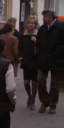

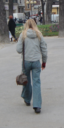

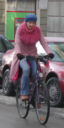

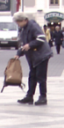

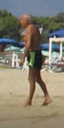

In [3]:
# Veamos 5 imágenes al azar del folder de positivos
draw_random_sample(POSITIVE)

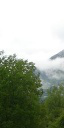

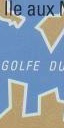

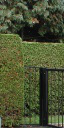

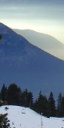

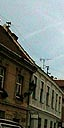

In [4]:
# Ahora del folder de negativos
draw_random_sample(NEGATIVE)

Fold #1 - accuracy: 96.19%


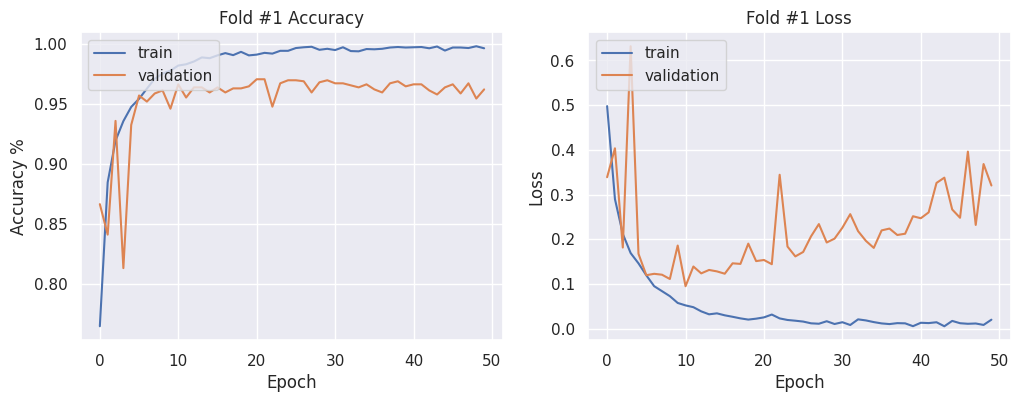

Fold #2 - accuracy: 95.26%


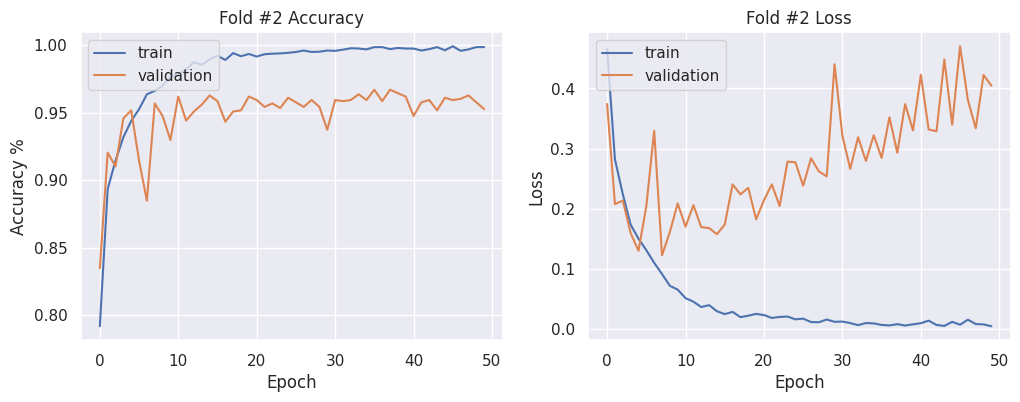

Fold #3 - accuracy: 95.94%


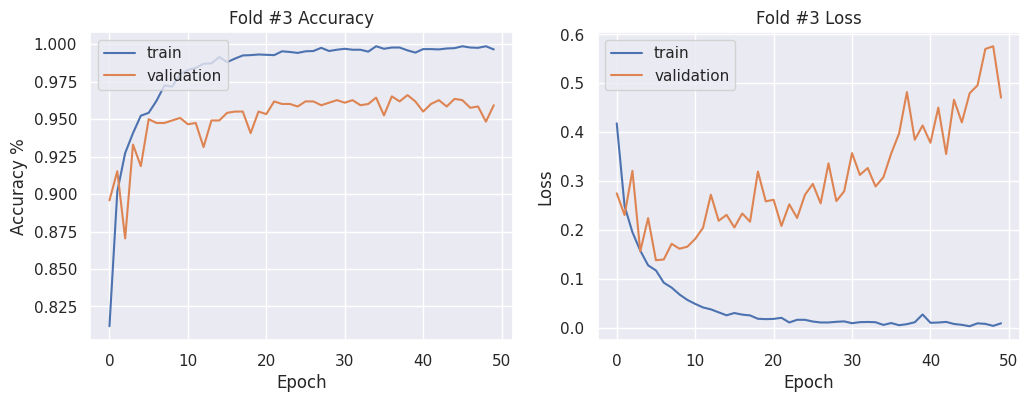

Fold #4 - accuracy: 95.51%


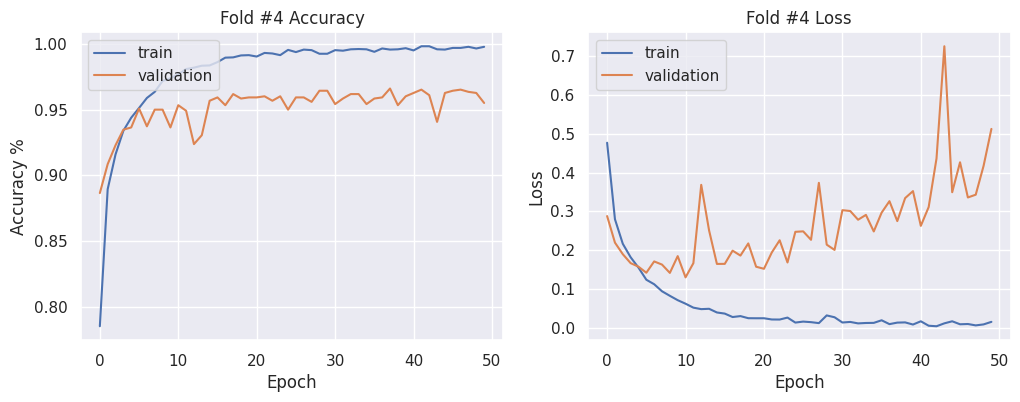

Fold #5 - accuracy: 96.78%


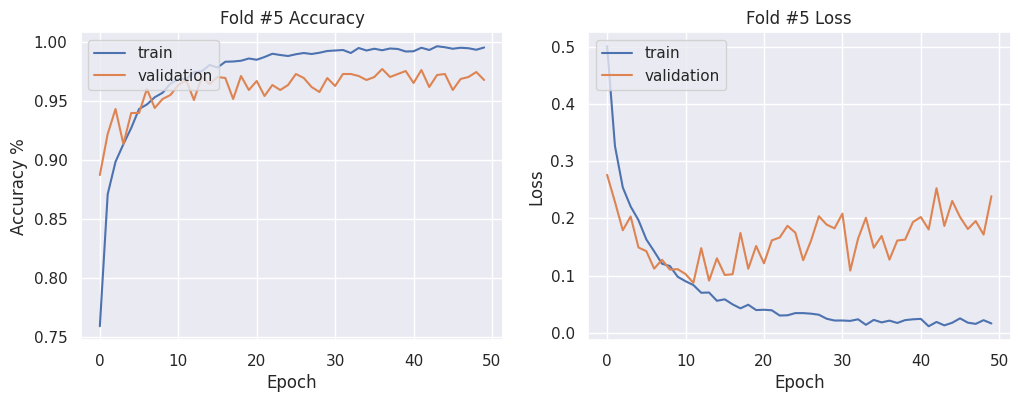

Average Score: 95.94% +/- 0.53%


In [5]:
# Dado que todo se ve correcto, podemos avanzar.
# Vamos a hacer un primer intento y construir la red neuronal para detectar
# a los peatones.

# Primero, vamos a hacer una pequeña función de pre-procesamiento de las
# imágenes

def load_and_process_image(image_path):
    # Ruta
    img = Image.open(image_path)

    # Reescalar y convertir a RGB
    img = img.resize((128, 64))
    img = img.convert('RGB')

    # Convertir a arreglo de numpy y normalizar
    img_array = np.array(img) / 255.0

    return img_array

# Importamos las librerías de tensorflow y keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split

# Parámetros
img_width, img_height = 64, 128
batch_size = 32
epochs = 50

# Cargas imágenes y etiquetas
images = []
labels = []

for filename in os.listdir(POSITIVE):
    images.append(load_and_process_image(os.path.join(POSITIVE, filename)))
    labels.append(1)  # peatón

for filename in os.listdir(NEGATIVE):
    images.append(load_and_process_image(os.path.join(NEGATIVE, filename)))
    labels.append(0)  # no peatón

images = np.array(images)
labels = np.array(labels)

# Vamos a apartar 10% de las imágenes para que sean nuestro conjunto de
# pruebas final

X_train, X_test, y_train, y_test = train_test_split(images, labels,
                                                    test_size=0.1,
                                                    random_state=42)

# Como primera aproximación, vamos a definir un modelo muy sencillo de
# redes neuronales convolucionales (CNN, por sus siglas en inglés)
def create_model():
    model = Sequential()
    # La primera capa es una capa convolucional. Son efectivas para procesar
    # arreglos matriciales de datos, como imágenes. Típicamente, se considera
    # que detectan patrones locales como bordes, formas y texturas en las
    # capas tempranas de las redes. En capas más profundas, pueden detectar
    # estructuras más abstractas (como ojos o labios). Los parámetros son
    # (32, (3, 3)), lo que significa que usa 32 filtros de 3x3
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
    # Las capas de agrupamiento (pooling) se usan para disminuir el tamaño
    # de la entrada, en términos de dimensión (se reduce el ancho y
    # el alto), pero se retiene suficiente información. Agrupamiento por
    # máximos (Max Pooling) toma el valor máximo de la ventana definida por
    # el pool_size. Dado que estas capas reducen la dimensionalidad,
    # tienen dos beneficios:
    # 1. Ayudan a disminuir el sobre-ajuste
    # 2. Disminuyen la carga computacional
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Otra capa convolucional, a partir de las imágenes reducidas que produce
    # el Max Pooling
    model.add(Conv2D(32, (3, 3), activation='relu'))
    # Este es un patrón típico en detección de imágenes: una capa convolucional
    # seguida por una capa de agrupamiento (pooling). Max Pooling suele ser
    # efectiva y rápida
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Transforma la entrada anterior 2D en un vector 1D. Esto es importante
    # porque las capas de neuronas densamente conectadas esperan un vector
    # 1D. La siguiente capa después del aplanamiento (flatten) es una capa
    # densamente conectada
    model.add(Flatten())
    # A continuación, hemos agregado una capa completamente conectada.
    # Esta capa hace la clasificación de las características extraídas
    # por las capas convolucionales, que luego se reducen con las capas
    # de agrupamiento. En una capa densamente conectada, todos los nodos
    # de la capa están conectados a todos los nodos de la capa anterior
    model.add(Dense(64, activation='relu'))
    # Las capas de abandono implementan un método de regularización que
    # disminuye el sobre-ajuste
    model.add(Dropout(0.5))
    # La capa final es densamente conectada, pero solo tiene 1 neurona, puesto
    # que la salida esperada de nuestro modelo es binaria. Por esta misma
    # razón, hemos usado la función de activación sigmoidal
    model.add(Dense(1, activation='sigmoid'))
    # La salida de este modelo es binaria, por lo que utilizamos como función
    # de pérdida la entropía cruzada binaria.
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

# Validación cruzada. Estamos usando 5 pliegues para esta prueba inicial.
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cvscores = []

i = 1
for train, val in kfold.split(X_train, y_train):
    # Corremos el modelo para cada uno de los pliegues
    model = create_model()
    history = model.fit(images[train], labels[train], 
                        validation_data=(images[val], labels[val]),
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=0)

    # Evaluación del modelo
    scores = model.evaluate(images[val], labels[val], verbose=0)
    print(f"Fold #{i} - {model.metrics_names[1]}: {scores[1]:.2%}")
    cvscores.append(scores[1])

    # Generación de gráfico de accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Fold #{i} Accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # Graficamos también la pérdida (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Fold #{i} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    i += 1

print(f"Average Score: {np.mean(cvscores):.2%} +/- {np.std(cvscores):.2%}")

Fold #1 - accuracy: 95.68%


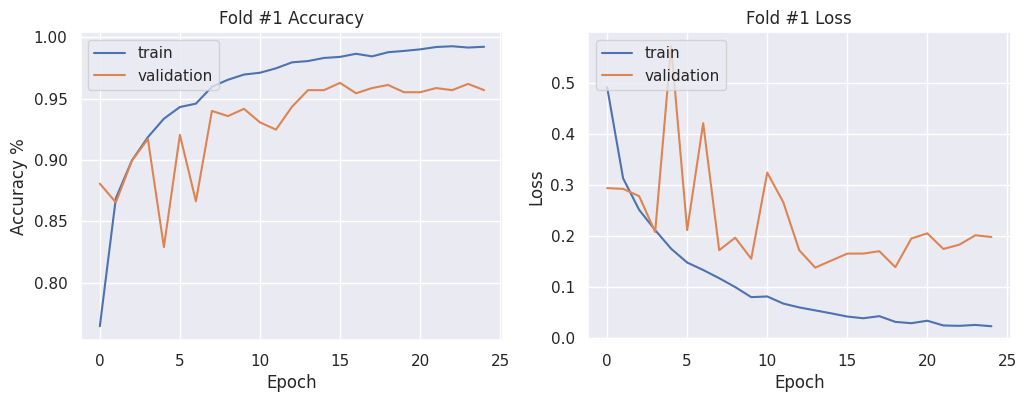

Fold #2 - accuracy: 96.02%


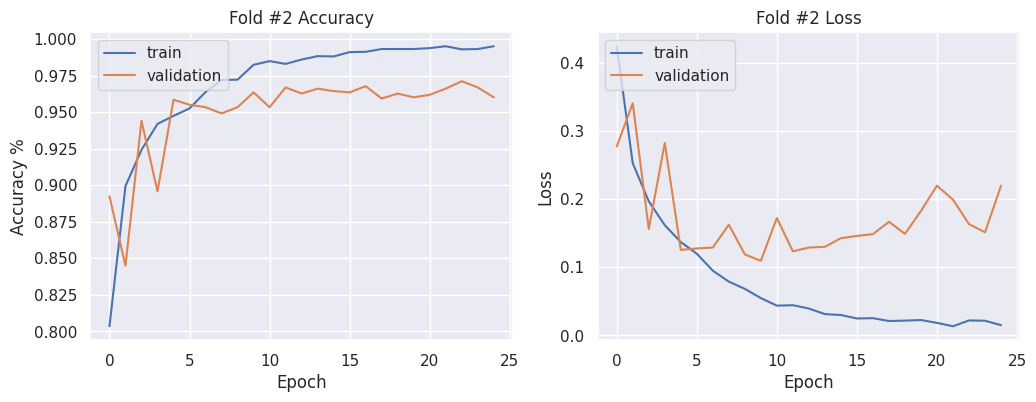

Fold #3 - accuracy: 95.43%


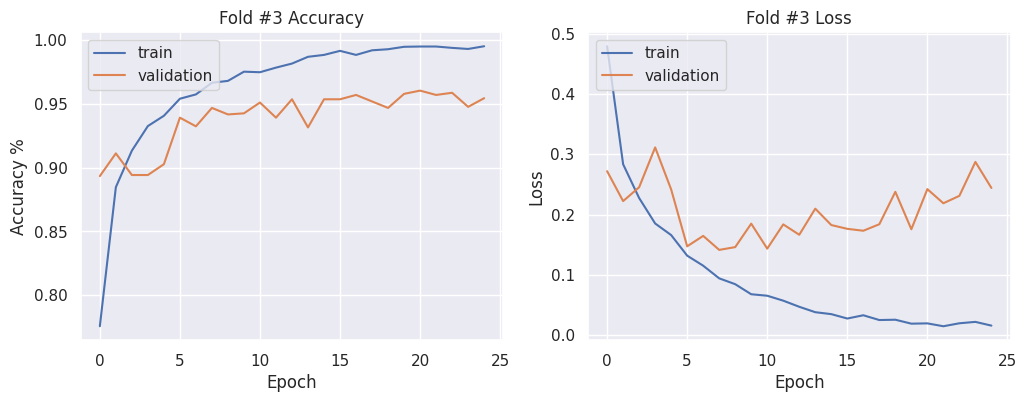

Fold #4 - accuracy: 95.68%


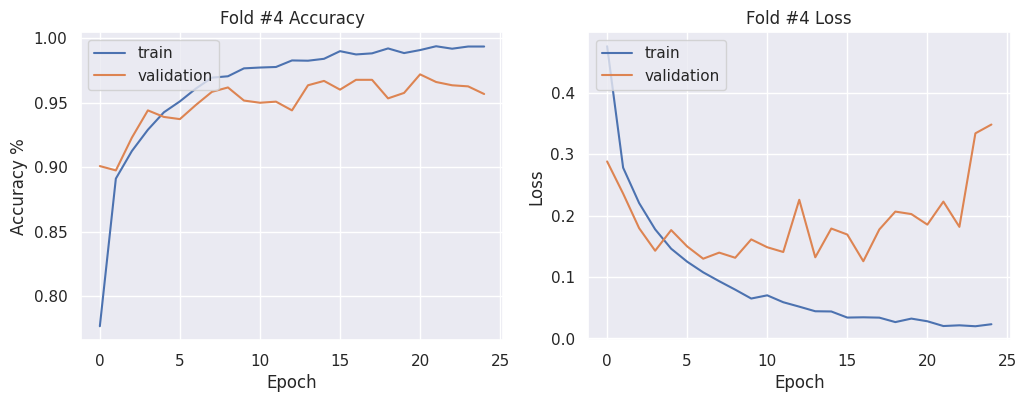

Fold #5 - accuracy: 95.09%


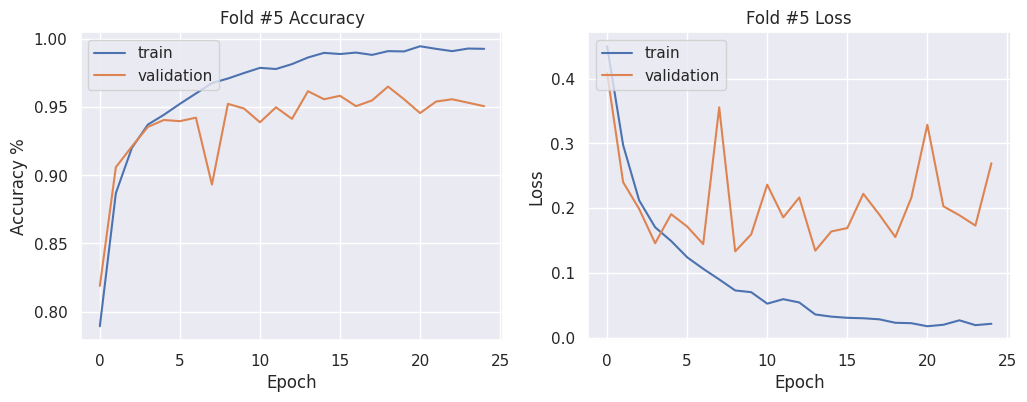

Average Score: 95.58% +/- 0.31%


In [6]:
# En promedio, entre los 5 pliegues tenemos un accuracy > 95%. Esto significa
# que el modelo se comporta bien. Sin embargo, es posible que estemos 
# sobre-entrenando porque después de 25 Epochs ya no observamos
# una mejora sustancial ni en accuracy ni vemos que disminuya la pérdida.
# Vamos a hacer un experimento de nuevo; esta vez, vamos a entrenar por 25
# Epochs únicamente. El objetivo es que el tiempo de entrenamiento
# del modelo productivo se reduzca

# Parámetros
img_width, img_height = 64, 128
batch_size = 32
epochs = 25

# Validación cruzada. Estamos usando 5 pliegues para esta prueba inicial.
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cvscores = []

i = 1
for train, val in kfold.split(X_train, y_train):
    # Corremos el modelo para cada uno de los pliegues
    model_fewer_epochs = create_model()
    history = model_fewer_epochs.fit(images[train], labels[train], 
                        validation_data=(images[val], labels[val]),
                        epochs=epochs, 
                        batch_size=batch_size,
                        verbose=0)

    # Evaluación del modelo
    scores = model_fewer_epochs.evaluate(images[val], labels[val], verbose=0)
    print(f"Fold #{i} - {model_fewer_epochs.metrics_names[1]}: {scores[1]:.2%}")
    cvscores.append(scores[1])

    # Generación de gráfico de accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Fold #{i} Accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # Graficamos también la pérdida (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Fold #{i} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    i += 1

print(f"Average Score: {np.mean(cvscores):.2%} +/- {np.std(cvscores):.2%}")

In [7]:
# Reentrenamos nuestro modelo inicial con el set completo de imágenes del set
# de entrenamiento y luego probamos con el set de prueba
model_final = create_model()
history = model_final.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=25, 
                    batch_size=32,
                    verbose=0)

# Evaluación del modelo
scores = model_final.evaluate(X_test, y_test, verbose=0)
print(f"Model training - {model_final.metrics_names[1]}: {scores[1]:.2%}")

Model training - accuracy: 96.35%
